Clean data

In [3]:
import pandas as pd
import re
import nltk
import swifter
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud

In [ ]:
# Membaca dataset terlebih dahulu
df_shopee_cod = pd.read_csv("../data/shopee_review_scraped.csv")

# Memilih hanya kolom 'userName', 'score', 'at', 'content'
new_df = df_shopee_cod[['userName', 'score', 'at', 'content']]

# Menampilkan 5 baris pertama untuk cek hasil
new_df.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  
0  Shopee yang sekarang kualitasnya bagus tetapi ...  
1  Apk belanja yang mudah dan beragam pilihan tok...  
2  Tidak bisa melakukan pembayaran listrik, dan p...  
3  Sudah dua bulan, setiap buka langsung diarahin...  
4  Aplikasi paling ga jelas, hp ku restart ulang ...

Data duplikat 

In [40]:
# Mengecek jumlah duplikasi dalam kolom 'content'
jumlah_duplikasi = new_df.duplicated(subset=['content']).sum()
print(f"Jumlah duplikasi dalam kolom 'content': {jumlah_duplikasi}")

Jumlah duplikasi dalam kolom 'content': 0


Menghapus Mention & Hashtag

In [41]:
def remove_mentions_hashtags(content):
    content = re.sub(r'@[A-Za-z0-9]+', ' ', content)  # Menghapus mention (@username)
    content = re.sub(r'#[A-Za-z0-9]+', ' ', content)  # Menghapus hashtag (#tag)
    return content

Menghapus URL

In [42]:
def remove_urls(content):
    return re.sub(r"http\S+", ' ', content)

Menghapus Angka

In [43]:
def remove_numbers(content):
    return re.sub(r'[0-9]+', ' ', content)

Menghapus Karakter Khusus & Tanda Baca

In [44]:
def remove_special_characters(content):
    return re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", content)


Menghapus Emoji

In [45]:
def remove_emojis(content):
    return content.encode('ascii', 'ignore').decode('ascii')

Menghapus Karakter Berulang (3x atau lebih → jadi 1x)

In [46]:
def replace_repeated_characters(content):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', content)


 Case Folding (Mengubah ke Huruf Kecil)

In [47]:
def case_folding(content):
    return content.lower().strip()

Menerapkan Fungsi ke DataFrame

In [48]:
new_df_copy = new_df.copy()

new_df_copy['No Mentions & Hashtags'] = new_df_copy['content'].apply(remove_mentions_hashtags)
new_df_copy['No URLs'] = new_df_copy['No Mentions & Hashtags'].apply(remove_urls)
new_df_copy['No Numbers'] = new_df_copy['No URLs'].apply(remove_numbers)
new_df_copy['No Special Characters'] = new_df_copy['No Numbers'].apply(remove_special_characters)
new_df_copy['No Emojis'] = new_df_copy['No Special Characters'].apply(remove_emojis)
new_df_copy['No Repeated Characters'] = new_df_copy['No Emojis'].apply(replace_repeated_characters)
new_df_copy['Case Folding'] = new_df_copy['No Repeated Characters'].apply(case_folding)

sorted_df = new_df_copy.sort_values(by='at', ascending=False)

In [49]:
new_df_copy.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  
0  shopee yang sekarang kualitasnya bagus tetapi ...  
1  apk belanja yang mudah dan beragam pilihan tok...  
2  tidak bisa melakukan pembayaran listrik  dan p...  
3  sudah dua bulan  setiap buka langsung diarahin...  
4  aplikasi paling ga jelas  hp ku restart ulang ...

Tokenisasi

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def tokenizing_text(content):
    return word_tokenize(content)

# Menerapkan tokenisasi ke kolom "Case Folding"
new_df_copy['Tokenizing'] = new_df_copy['Case Folding'].apply(tokenizing_text)


In [52]:
new_df_copy.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  
0  [shopee, yang, sekarang, kualitasnya, bagus, t...  
1  [apk, belanja, yang, mudah, dan, beragam, pili...  
2  [tidak, bisa, melakukan, pembayaran, listrik, ...  
3  [sudah, dua, bulan, setiap, buka, langsung, di...  
4  [aplikasi, paling, ga, jelas, hp, ku, restart,...

Formalisasi

In [53]:
def convertToSlangword(tokens):
    # Load slang word dictionary from a file
    with open("../data/slangwords.txt", "r") as file:
        kamusSlang = eval(file.read())

    pattern = re.compile(r'\b(' + '|'.join(kamusSlang.keys()) + r')\b')
    content = []

    for kata in tokens:
        filterSlang = pattern.sub(lambda x: kamusSlang[x.group()], kata)
        content.append(filterSlang.lower())

    return content

# Assuming 'new_df' contains the data
new_df_copy['Formalisasi'] = new_df_copy['Tokenizing'].apply(convertToSlangword)

In [56]:
new_df_copy.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  [shopee, yang, sekarang, kualitasnya, bagus, t...   
1  [apk, belanja, yang, mudah, dan, beragam, pili...   
2  [tidak, bisa, melakukan, pembayaran, listrik, ...   
3  [sudah, dua, bulan, setiap, buka, langsung, di...   
4  [aplikasi, paling, ga, jelas, hp, ku, restart,...   

                                         Formalisasi  
0  [shopee, yang, sekarang, kualitasnya, bagus, t...  
1  [aplikasi, belanja, yang, mudah, dan, beragam,...  
2  [tidak, bisa, melakukan, pembayaran, listrik, ...  
3  [sudah, dua, bulan, setiap, buka, langsung, di...  
4  [aplikasi, paling, ga, jelas, seluler, ku, res...

Penghapusan Stopwords (stopwordText)

In [ ]:
nltk.download('stopwords')

daftar_stopword = stopwords.words('indonesian')
# Append additional stopwords
daftar_stopword.extend(["yg", "dg", "rt"])  # Tambahan kata stopword manual
daftar_stopword = set(daftar_stopword)  # Konversi ke set untuk efisiensi

def stopwordText(words):
    return [word for word in words if word not in daftar_stopword]

# Menghapus stopwords dari hasil tokenisasi
new_df_copy['WithoutStopwords'] = new_df_copy['Tokenizing'].apply(stopwordText)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stemming (stemmingText)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

# Membangun kamus kata-kata yang sudah di-stem
for document in new_df_copy['WithoutStopwords']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '  # Placeholder

# Proses stemming
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term, ":", term_dict[term])  # Debugging untuk melihat hasil stemming

def stemmingText(document):
    return [term_dict[term] for term in document]

# Menerapkan stemming ke teks
new_df_copy['Stemming'] = new_df_copy['WithoutStopwords'].swifter.apply(stemmingText)


shopee : shopee
kualitasnya : kualitas
bagus : bagus
parahnya : parah
pengiriman : kirim
sistemnya : sistem
mengutamakan : utama
ekspedisi : ekspedisi
express : express
pelanggan : langgan
kecewa : kecewa
paket : paket
x : x
dilaporan : lapor
kurir : kurir
ditugaskan : tugas
diantar : antar
kurirnya : kurir
wa : wa
diantarkan : antar
menanggapi : tanggap
paketnya : paket
laporannya : lapor
penerima : terima
ditempat : tempat
dihubungi : hubung
dikembalikan : kembali
pengirim : kirim
gila : gila
gak : gak
sih : sih
apk : apk
belanja : belanja
mudah : mudah
beragam : agam
pilihan : pilih
toko : toko
terpercaya : percaya
voucher : voucher
terkadang : terkadang
ongkos : ongkos
kirim : kirim
mahal : mahal
promo : promo
menarik : tarik
event : event
transparan : transparan
mengadakan : ada
flash : flash
sale : sale
tanggal : tanggal
cantik : cantik
masyarakat : masyarakat
bingung : bingung
serba : serba
kali : kali
mengikuti : ikut
tsb : tsb
minim : minim
peluang : peluang
hadiah : hadiah
ka

Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 371131.36it/s]


In [27]:
new_df_copy.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  [shopee, yang, sekarang, kualitasnya, bagus, t...   
1  [apk, belanja, yang, mudah, dan, beragam, pili...   
2  [tidak, bisa, melakukan, pembayaran, listrik, ...   
3  [sudah, dua, bulan, setiap, buka, langsung, di...   
4  [aplikasi, paling, ga, jelas, hp, ku, restart,...   

                                         Formalisasi  \
0  [shopee, yang, sekarang, kualitasnya, bagus, t...   
1  [aplikasi, belanja, yang, mudah, dan, beragam,...   
2  [tidak, bisa, melakukan, pembayaran, listrik, ...   
3  [sudah, dua, bulan, setiap, buka, langsung, di...   
4  [aplikasi, paling, ga, jelas, seluler, ku, res...   

                                    WithoutStopwords  \
0  [shopee, kualitasnya, bagus, parahnya, pengiri...   
1  [apk, belanja, mudah, beragam, pilihan, toko, ...   
2  [pembayaran, listrik, pembayaran, tulisan, dow...   
3  [buka, langsung, diarahin, live, video, suka, ...   
4  [aplikasi, ga, hp, ku, restart, ulang, datanya...   

  

In [59]:
new_df_copy.to_csv('../data/data_clean/hasil_stemming.csv', index=False, encoding='utf-8')

In [ ]:
from googletrans import Translator
translator = Translator()

def translate_to_english(text):
    try:
        return translator.translate(" ".join(text), dest='en').text
    except:
        return "Translation Error"

# Menerapkan terjemahan ke kolom hasil stemming
new_df_copy['EnglishTranslation'] = new_df_copy['Stemming'].apply(translate_to_english)


In [31]:
new_df_copy.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  [shopee, yang, sekarang, kualitasnya, bagus, t...   
1  [apk, belanja, yang, mudah, dan, beragam, pili...   
2  [tidak, bisa, melakukan, pembayaran, listrik, ...   
3  [sudah, dua, bulan, setiap, buka, langsung, di...   
4  [aplikasi, paling, ga, jelas, hp, ku, restart,...   

                                         Formalisasi  \
0  [shopee, yang, sekarang, kualitasnya, bagus, t...   
1  [aplikasi, belanja, yang, mudah, dan, beragam,...   
2  [tidak, bisa, melakukan, pembayaran, listrik, ...   
3  [sudah, dua, bulan, setiap, buka, langsung, di...   
4  [aplikasi, paling, ga, jelas, seluler, ku, res...   

                                    WithoutStopwords  \
0  [shopee, kualitasnya, bagus, parahnya, pengiri...   
1  [apk, belanja, mudah, beragam, pilihan, toko, ...   
2  [pembayaran, listrik, pembayaran, tulisan, dow...   
3  [buka, langsung, diarahin, live, video, suka, ...   
4  [aplikasi, ga, hp, ku, restart, ulang, datanya...   

  

Export to csv

In [37]:
new_df_copy.to_csv('../data/data_clean/hasil_cleaning.csv', index=False, encoding='utf-8')

TextBloob

In [ ]:
# Membaca dataset terlebih dahulu
df_textBlob = pd.read_csv("../data/data_clean/hasil_cleaning.csv", on_bad_lines='skip')

# Menampilkan 5 baris pertama untuk cek hasil
df_textBlob.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['apk', 'belanja', 'yang', 'mudah', 'dan', 'be...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'hp', 'k...   

                                         Formalisasi  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['aplikasi', 'belanja', 'yang', 'mudah', 'dan'...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'seluler...   

                                    WithoutStopwords  \
0  ['shopee', 'kualitasnya', 'bagus', 'parahnya',...   
1  ['apk', 'belanja', 'mudah', 'beragam', 'piliha...   
2  ['pembayaran', 'listrik', 'pembayaran', 'tulis...   
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...   
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...   

  

In [ ]:
def analyze_sentiment(text):
    try:
        sentiment_score = TextBlob(str(text)).sentiment.polarity
        if sentiment_score > 0:
            return "Positive"
        elif sentiment_score < 0:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Error"


In [6]:
df_textBlob['Sentiment'] = df_textBlob['EnglishTranslation'].apply(analyze_sentiment)

In [7]:
df_textBlob_filtered = df_textBlob[['userName', 'score', 'at', 'EnglishTranslation', 'Sentiment']]

# Tampilkan 10 baris pertama untuk dicek
df_textBlob_filtered.head(10)

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   
5  Pengguna Google      2  2025-03-15 08:13:43   
6  Pengguna Google      5  2025-03-15 11:22:43   
7  Pengguna Google      1  2025-03-15 10:55:47   
8  Pengguna Google      5  2025-03-15 08:14:08   
9  Pengguna Google      1  2025-03-13 15:01:27   

                                  EnglishTranslation Sentiment  
0  Shopee Good quality Severe Sending the main sy...  Negative  
1  Apk Shopping Easily Agam Choose a Shop Believe...  Positive  
2  Pay Electricity Pay Write Download the Loading...  Negative  
3  Open directly on Live Video like the method of...  Negative  
4  The application is not re -restarted the data ...  Positive  
5  Ken shopping using ShoopePay Limited Items Dur...  Positive  
6  help women lazy shopping eheheh looking for sh...  Positive  
7  open the shopee application automatically the ...  Negative  
8  Shopee is good, it's not a smooth constraint f...  Positive  
9  The transaction canceled the system already tr...  Negative

In [8]:
df_textBlob_filtered.to_csv("../data/data_clean/hasil_sentimentAnalysis_textBlob.csv", index=False, encoding='utf-8')

BERT

In [10]:
# Membaca dataset terlebih dahulu
df_BERT = pd.read_csv("../data/data_clean/hasil_cleaning.csv", on_bad_lines='skip')

# Menampilkan 5 baris pertama untuk cek hasil
df_BERT.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['apk', 'belanja', 'yang', 'mudah', 'dan', 'be...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'hp', 'k...   

                                         Formalisasi  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['aplikasi', 'belanja', 'yang', 'mudah', 'dan'...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'seluler...   

                                    WithoutStopwords  \
0  ['shopee', 'kualitasnya', 'bagus', 'parahnya',...   
1  ['apk', 'belanja', 'mudah', 'beragam', 'piliha...   
2  ['pembayaran', 'listrik', 'pembayaran', 'tulis...   
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...   
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...   

  

In [ ]:
# Load tokenizer dan model BERT
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

d:\Python 3.10.7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Python 3.10.7\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode

Fungsi untuk Memprediksi Sentimen dengan BERT

In [12]:
def predict_sentiment(text):
    try:
        # Tokenisasi teks
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        
        # Prediksi dengan model
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Ambil hasil prediksi
        scores = outputs.logits.softmax(dim=1).tolist()[0]
        label = scores.index(max(scores)) + 1  # Skala 1-5

        # Konversi ke kategori sentimen
        if label <= 2:
            return "Negative"
        elif label == 3:
            return "Neutral"
        else:
            return "Positive"

    except Exception as e:
        return f"Error: {str(e)}"

Terapkan Model ke Data

In [ ]:
df_BERT['BERT_Sentiment'] = df_BERT['EnglishTranslation'].astype(str).apply(predict_sentiment)

# Tampilkan hasil
df_BERT_filtered = df_BERT[['userName', 'score', 'at', 'EnglishTranslation', 'BERT_Sentiment']]
df_BERT_filtered.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                  EnglishTranslation BERT_Sentiment  
0  Shopee Good quality Severe Sending the main sy...       Negative  
1  Apk Shopping Easily Agam Choose a Shop Believe...       Negative  
2  Pay Electricity Pay Write Download the Loading...       Negative  
3  Open directly on Live Video like the method of...       Negative  
4  The application is not re -restarted the data ...       Negative

In [15]:
df_BERT_filtered.to_csv("../data/data_clean/hasil_sentimentAnalysis_BERT.csv", index=False, encoding='utf-8')


Visualisai Data

Visualisasi Data TextBlob

In [22]:
# Load ulang hasil sentimen TextBlob dan BERT
df_textBlob_filtered = pd.read_csv("../data/data_clean/hasil_sentimentAnalysis_textBlob.csv")
df_BERT_filtered = pd.read_csv("../data/data_clean/hasil_sentimentAnalysis_BERT.csv")

 WordCloud untuk Sentimen - TextBlob

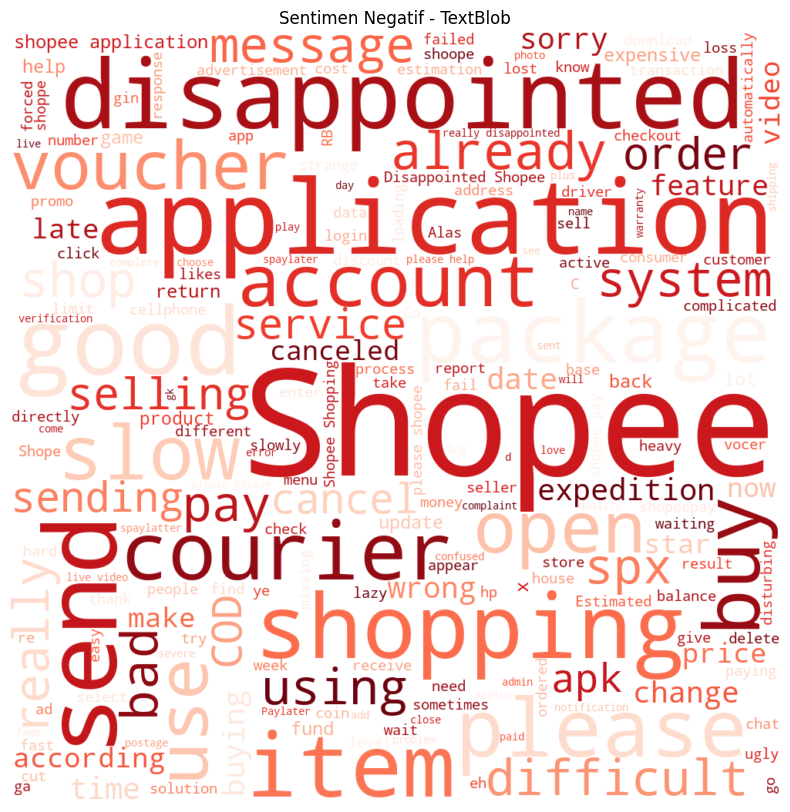

In [23]:
# WordCloud Sentimen Negatif (TextBlob)
text_neg_blob = ' '.join(df_textBlob_filtered[df_textBlob_filtered['Sentiment'] == 'Negative']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neg_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif - TextBlob")
plt.show()

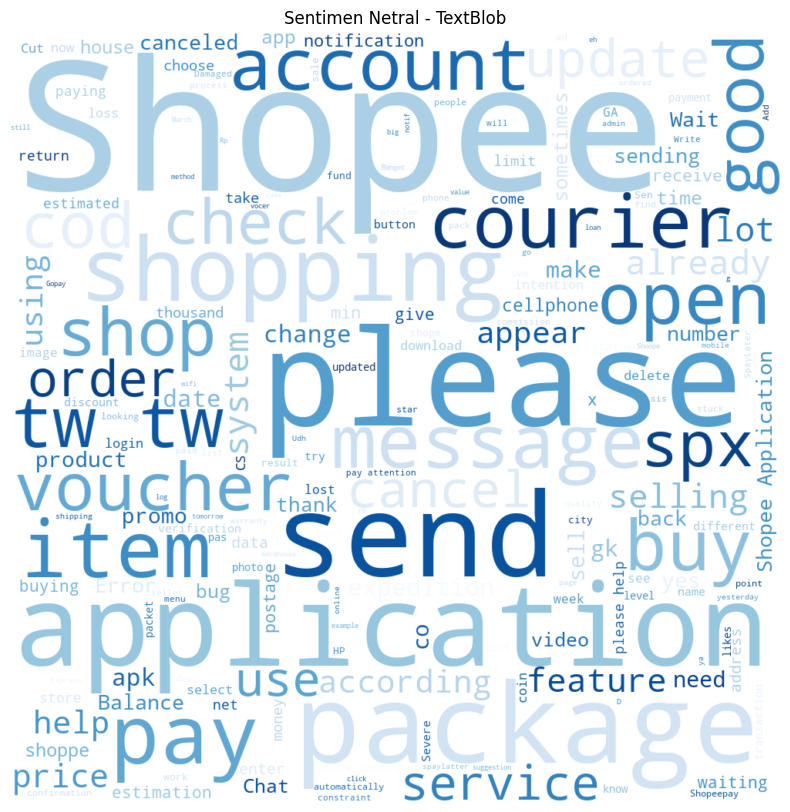

In [24]:
# WordCloud Sentimen Netral (TextBlob)
text_neu_blob = ' '.join(df_textBlob_filtered[df_textBlob_filtered['Sentiment'] == 'Neutral']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neu_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Netral - TextBlob")
plt.show()

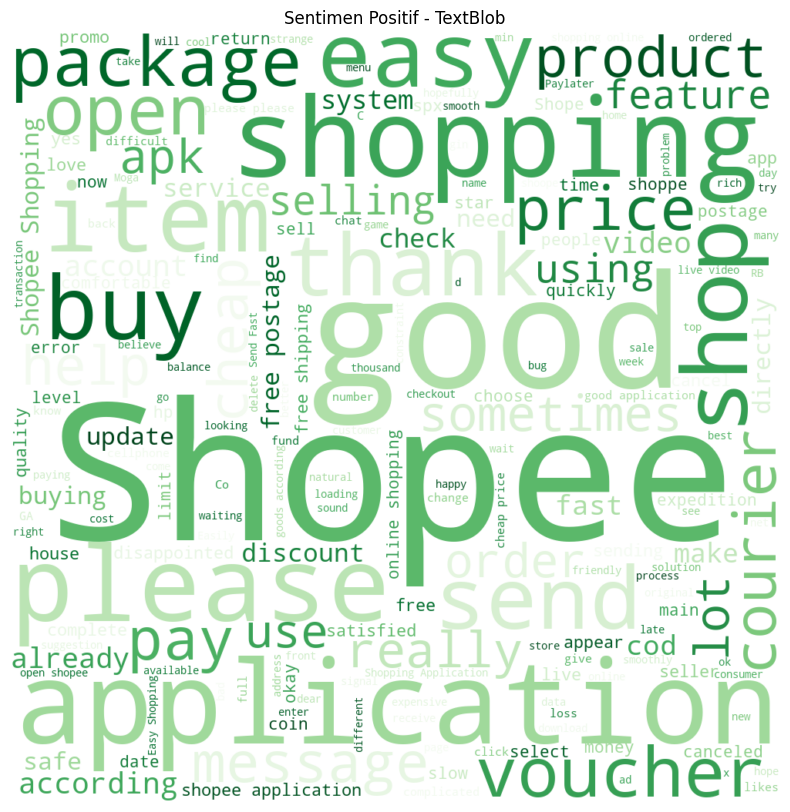

In [25]:
# WordCloud Sentimen Positif (TextBlob)
text_pos_blob = ' '.join(df_textBlob_filtered[df_textBlob_filtered['Sentiment'] == 'Positive']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_pos_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif - TextBlob")
plt.show()

WordCloud untuk Sentimen - BERT

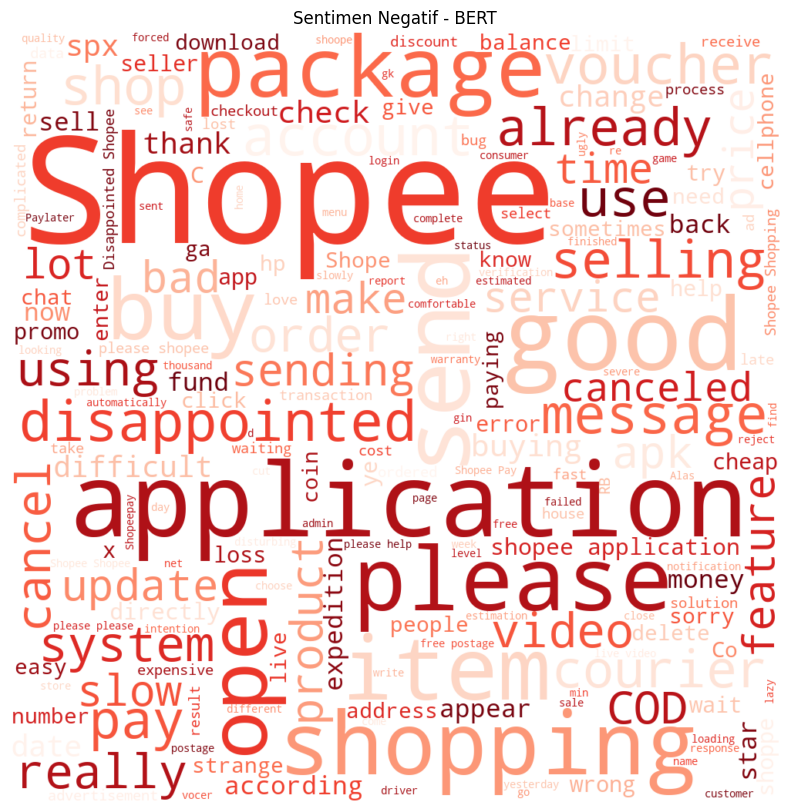

In [26]:
# WordCloud Sentimen Negatif (BERT)
text_neg_bert = ' '.join(df_BERT_filtered[df_BERT_filtered['BERT_Sentiment'] == 'Negative']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neg_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif - BERT")
plt.show()

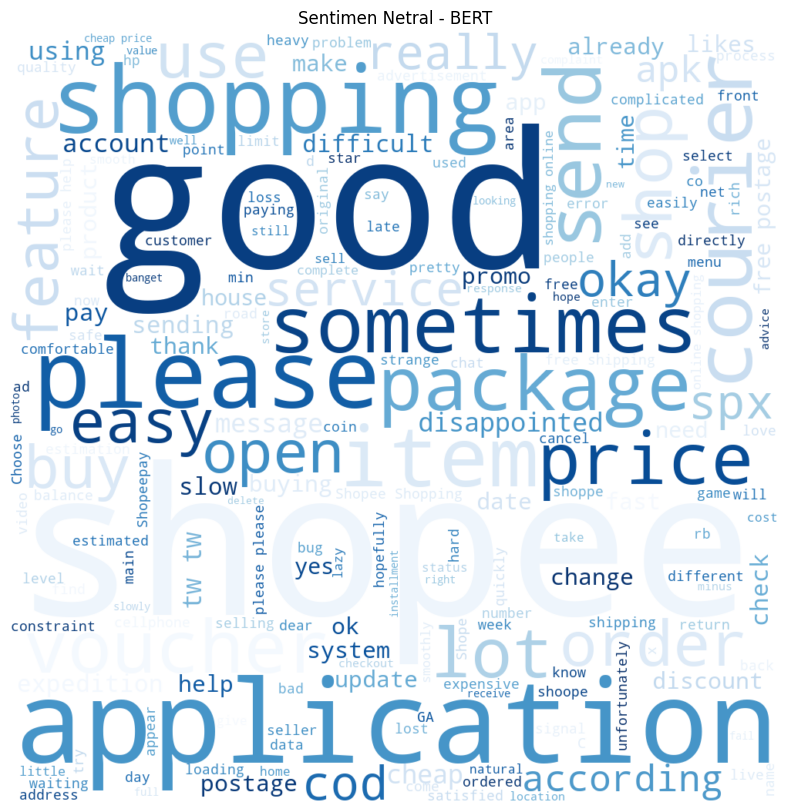

In [27]:
# WordCloud Sentimen Netral (BERT)
text_neu_bert = ' '.join(df_BERT_filtered[df_BERT_filtered['BERT_Sentiment'] == 'Neutral']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neu_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Netral - BERT")
plt.show()


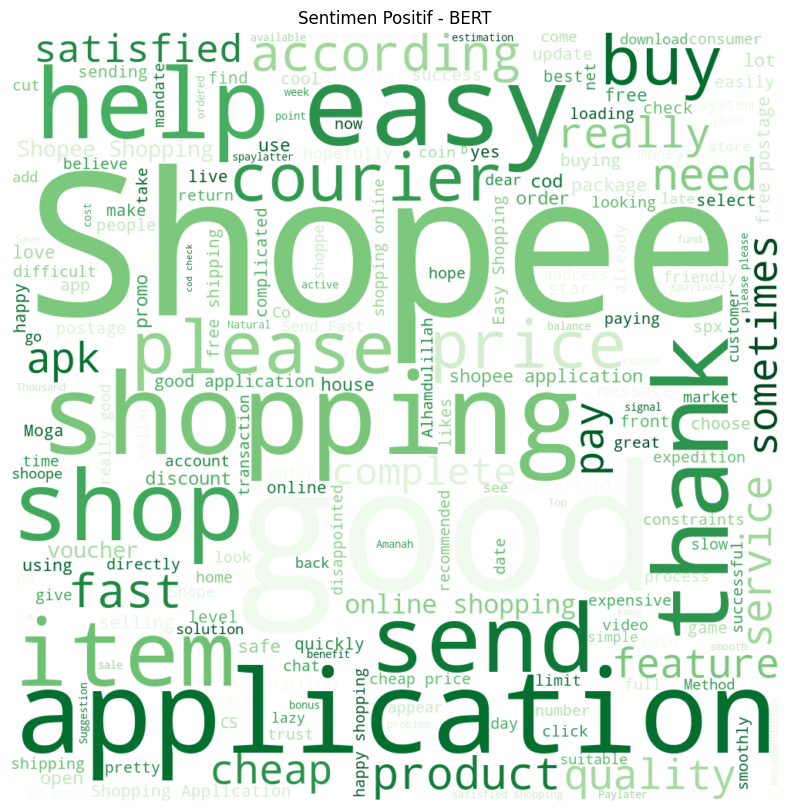

In [28]:
# WordCloud Sentimen Positif (BERT)
text_pos_bert = ' '.join(df_BERT_filtered[df_BERT_filtered['BERT_Sentiment'] == 'Positive']['EnglishTranslation'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_pos_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif - BERT")
plt.show()

Bar Chart Distribusi Sentimen

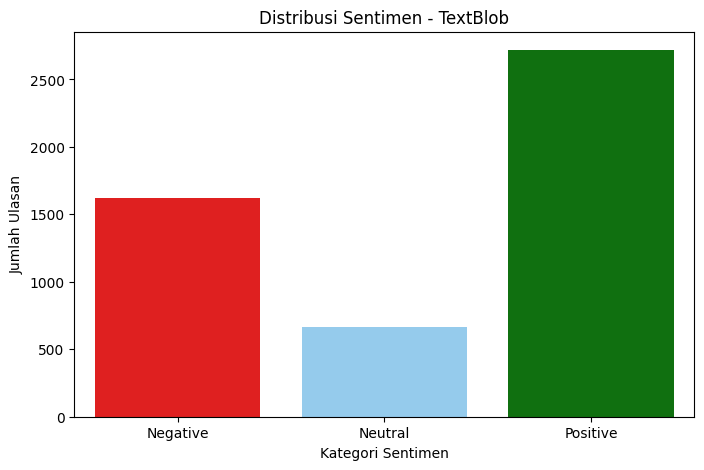

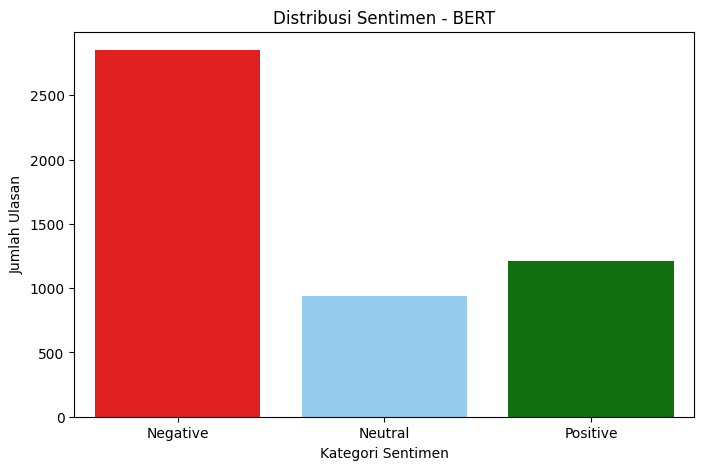

In [ ]:


# Hitung jumlah kategori sentimen untuk TextBlob
sentimen_blob = df_textBlob_filtered['Sentiment'].value_counts()

# Hitung jumlah kategori sentimen untuk BERT
sentimen_bert = df_BERT_filtered['BERT_Sentiment'].value_counts()

# Pastikan kategori diurutkan dengan benar
order = ['Negative', 'Neutral', 'Positive']
colors = {'Negative': 'red', 'Neutral': 'lightskyblue', 'Positive': 'green'}

# **Visualisasi Sentimen TextBlob**
plt.figure(figsize=(8, 5))
sns.barplot(x=sentimen_blob.index, y=sentimen_blob.values, hue=sentimen_blob.index, 
            order=order, palette=colors, legend=False)
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Sentimen - TextBlob")
plt.show()

# **Visualisasi Sentimen BERT**
plt.figure(figsize=(8, 5))
sns.barplot(x=sentimen_bert.index, y=sentimen_bert.values, hue=sentimen_bert.index, 
            order=order, palette=colors, legend=False)
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Sentimen - BERT")
plt.show()


Menganalisis menggunakan LLM DeepSeek

TextBlob

In [11]:
# Membaca dataset terlebih dahulu
df_DeepSeek_TextBlob = pd.read_csv("../data/data_clean/hasil_translation.csv")

df_DeepSeek_TextBlob .head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['apk', 'belanja', 'yang', 'mudah', 'dan', 'be...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'hp', 'k...   

                                         Formalisasi  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['aplikasi', 'belanja', 'yang', 'mudah', 'dan'...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'seluler...   

                                    WithoutStopwords  \
0  ['shopee', 'kualitasnya', 'bagus', 'parahnya',...   
1  ['apk', 'belanja', 'mudah', 'beragam', 'piliha...   
2  ['pembayaran', 'listrik', 'pembayaran', 'tulis...   
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...   
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...   

  

In [12]:
def analyze_sentiment(text):
    try:
        sentiment_score = TextBlob(str(text)).sentiment.polarity
        if sentiment_score > 0:
            return "Positive"
        elif sentiment_score < 0:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Error"
    
df_DeepSeek_TextBlob ['Sentiment'] = df_DeepSeek_TextBlob ['Translation'].apply(analyze_sentiment)

df_DeepSeek_TextBlob_filtered= df_DeepSeek_TextBlob [['userName', 'score', 'at', 'Translation', 'Sentiment']]

# Tampilkan 10 baris pertama untuk dicek
df_DeepSeek_TextBlob_filtered.head(10)

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   
5  Pengguna Google      2  2025-03-15 08:13:43   
6  Pengguna Google      5  2025-03-15 11:22:43   
7  Pengguna Google      1  2025-03-15 10:55:47   
8  Pengguna Google      5  2025-03-15 08:14:08   
9  Pengguna Google      1  2025-03-13 15:01:27   

                                         Translation Sentiment  
0  ['shopee', 'kualitas', 'bagus', 'parah', 'kiri...  Positive  
1  ['apk', 'belanja', 'mudah', 'agam', 'pilih', '...  Positive  
2  ['bayar', 'listrik', 'bayar', 'tulis', 'downlo...  Positive  
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...  Positive  
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...  Positive  
5  ['ken', 'belanja', 'pakai', 'shoopepay', 'bara...  Positive  
6  ['bantu', 'wanita', 'males', 'belanja', 'ehehe...  Positive  
7  ['buka', 'aplikasi', 'shopee', 'otomatis', 'se...  Positive  
8  ['shopee', 'bagus', 'bgt', 'ga', 'kendala', 'l...  Negative  
9  ['transaksi', 'batal', 'sistem', 'udah', 'nyob...   Neutral

In [ ]:
df_DeepSeek_TextBlob_filtered.to_csv("../data/data_clean/hasil_DeepSeek_textBlob.csv", index=False, encoding='utf-8')

BERT

In [ ]:
# Membaca dataset terlebih dahulu
df_DeepSeek_BERT = pd.read_csv("../data/data_clean/hasil_translation.csv")

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                             content  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                              No Mentions & Hashtags  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                             No URLs  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                                          No Numbers  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik, dan p...   
3  Sudah dua bulan, setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas, hp ku restart ulang ...   

                               No Special Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                           No Emojis  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                              No Repeated Characters  \
0  Shopee yang sekarang kualitasnya bagus tetapi ...   
1  Apk belanja yang mudah dan beragam pilihan tok...   
2  Tidak bisa melakukan pembayaran listrik  dan p...   
3  Sudah dua bulan  setiap buka langsung diarahin...   
4  Aplikasi paling ga jelas  hp ku restart ulang ...   

                                        Case Folding  \
0  shopee yang sekarang kualitasnya bagus tetapi ...   
1  apk belanja yang mudah dan beragam pilihan tok...   
2  tidak bisa melakukan pembayaran listrik  dan p...   
3  sudah dua bulan  setiap buka langsung diarahin...   
4  aplikasi paling ga jelas  hp ku restart ulang ...   

                                          Tokenizing  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['apk', 'belanja', 'yang', 'mudah', 'dan', 'be...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'hp', 'k...   

                                         Formalisasi  \
0  ['shopee', 'yang', 'sekarang', 'kualitasnya', ...   
1  ['aplikasi', 'belanja', 'yang', 'mudah', 'dan'...   
2  ['tidak', 'bisa', 'melakukan', 'pembayaran', '...   
3  ['sudah', 'dua', 'bulan', 'setiap', 'buka', 'l...   
4  ['aplikasi', 'paling', 'ga', 'jelas', 'seluler...   

                                    WithoutStopwords  \
0  ['shopee', 'kualitasnya', 'bagus', 'parahnya',...   
1  ['apk', 'belanja', 'mudah', 'beragam', 'piliha...   
2  ['pembayaran', 'listrik', 'pembayaran', 'tulis...   
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...   
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...   

  

In [15]:
# Load tokenizer dan model BERT
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [16]:
def predict_sentiment(text):
    try:
        # Tokenisasi teks
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        
        # Prediksi dengan model
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Ambil hasil prediksi
        scores = outputs.logits.softmax(dim=1).tolist()[0]
        label = scores.index(max(scores)) + 1  # Skala 1-5

        # Konversi ke kategori sentimen
        if label <= 2:
            return "Negative"
        elif label == 3:
            return "Neutral"
        else:
            return "Positive"

    except Exception as e:
        return f"Error: {str(e)}"
    

df_DeepSeek_BERT['BERT_Sentiment'] =df_DeepSeek_BERT['Translation'].astype(str).apply(predict_sentiment)

# Tampilkan hasil
df_DeepSeek_BERT_filtered = df_DeepSeek_BERT[['userName', 'score', 'at', 'Translation', 'BERT_Sentiment']]
df_DeepSeek_BERT_filtered.head()

userName  score                   at  \
0  Pengguna Google      1  2025-03-15 13:05:26   
1  Pengguna Google      4  2025-03-16 04:29:12   
2  Pengguna Google      1  2025-03-15 14:16:55   
3  Pengguna Google      1  2025-03-15 05:13:35   
4  Pengguna Google      1  2025-03-15 08:03:40   

                                         Translation BERT_Sentiment  
0  ['shopee', 'kualitas', 'bagus', 'parah', 'kiri...       Positive  
1  ['apk', 'belanja', 'mudah', 'agam', 'pilih', '...        Neutral  
2  ['bayar', 'listrik', 'bayar', 'tulis', 'downlo...       Positive  
3  ['buka', 'langsung', 'diarahin', 'live', 'vide...        Neutral  
4  ['aplikasi', 'ga', 'hp', 'ku', 'restart', 'ula...       Negative

In [17]:
df_DeepSeek_BERT_filtered.to_csv("../data/data_clean/hasil_DeepSeek_BERT.csv", index=False, encoding='utf-8')

Load data ulang untuk visual data

In [24]:
# Load ulang hasil sentimen TextBlob dan BERT
df_DeepSeek_textBlob = pd.read_csv("../data/data_clean/hasil_DeepSeek_textBlob.csv")
df_DeepSeek_BERT = pd.read_csv("../data/data_clean/hasil_DeepSeek_BERT.csv")


 WordCloud untuk Sentimen - TextBlob

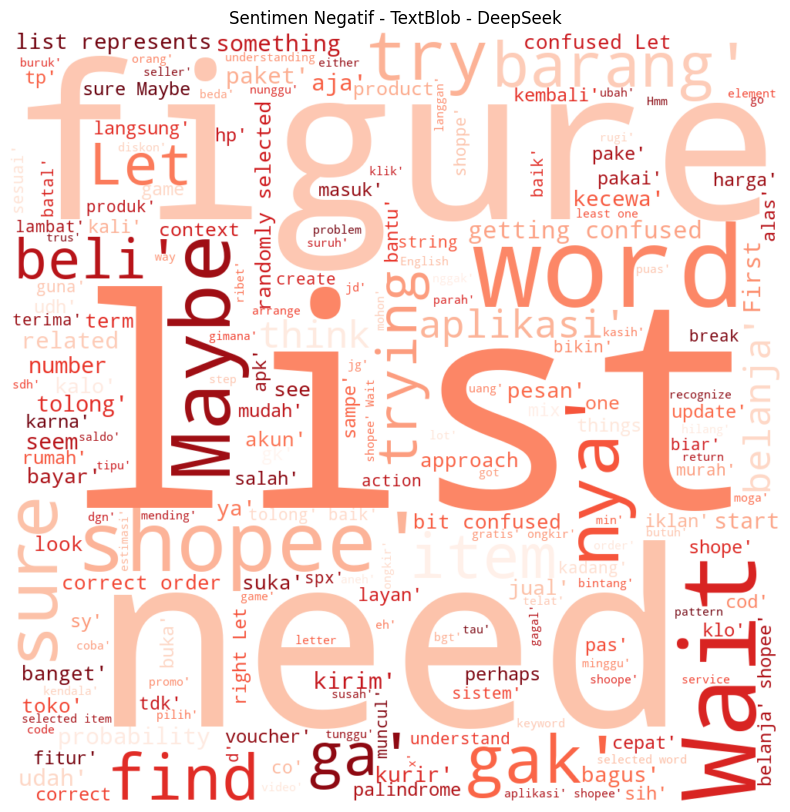

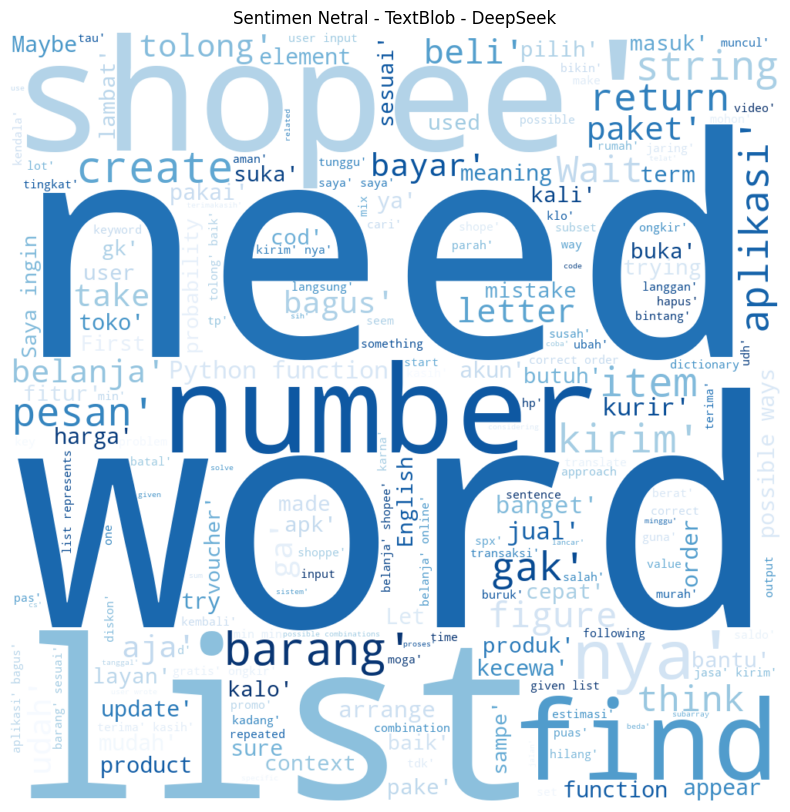

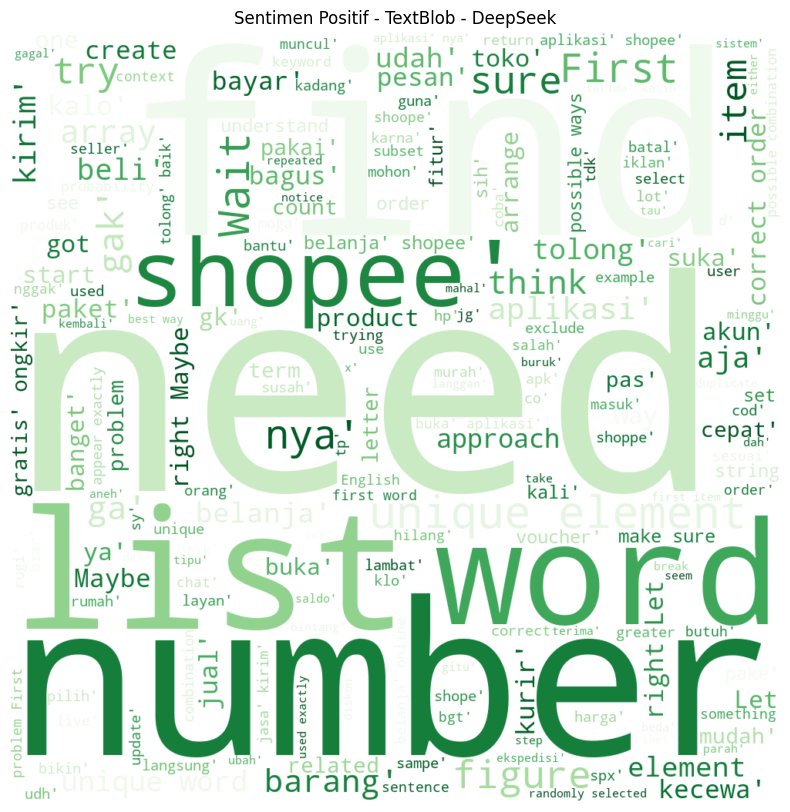

In [21]:
# WordCloud Sentimen Negatif (TextBlob)
text_neg_blob = ' '.join(df_DeepSeek_textBlob[df_DeepSeek_textBlob['Sentiment'] == 'Negative']['Translation'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neg_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif - TextBlob - DeepSeek")
plt.show()

# WordCloud Sentimen Netral (TextBlob)
text_neu_blob = ' '.join(df_DeepSeek_textBlob[df_DeepSeek_textBlob['Sentiment'] == 'Neutral']['Translation'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neu_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Netral - TextBlob - DeepSeek")
plt.show()

# WordCloud Sentimen Positif (TextBlob)
text_pos_blob = ' '.join(df_DeepSeek_textBlob[df_DeepSeek_textBlob['Sentiment'] == 'Positive']['Translation'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_pos_blob)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif - TextBlob - DeepSeek")
plt.show()

WordCloud untuk Sentimen - BERT

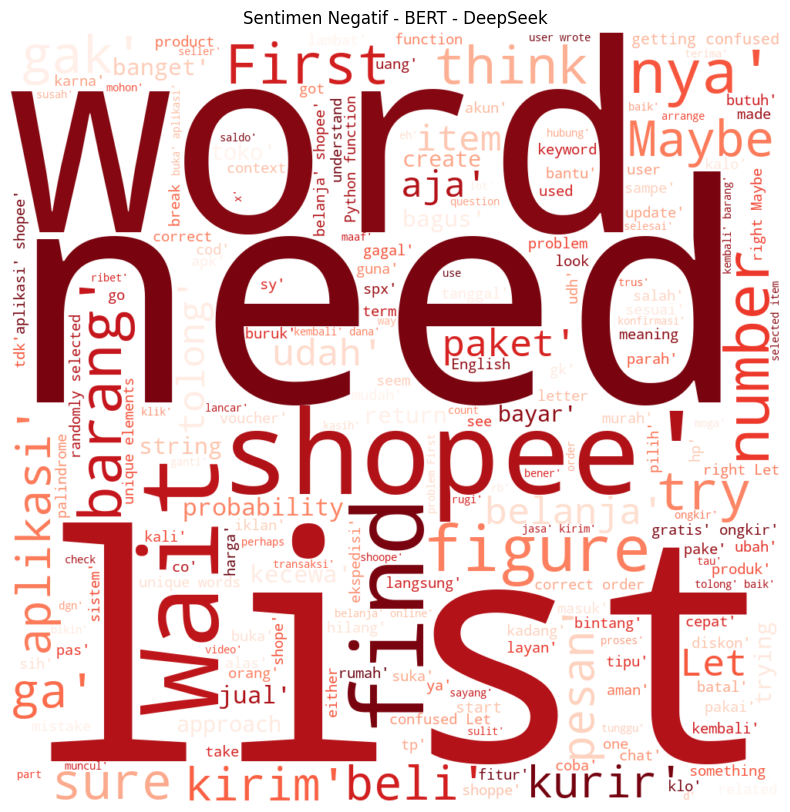

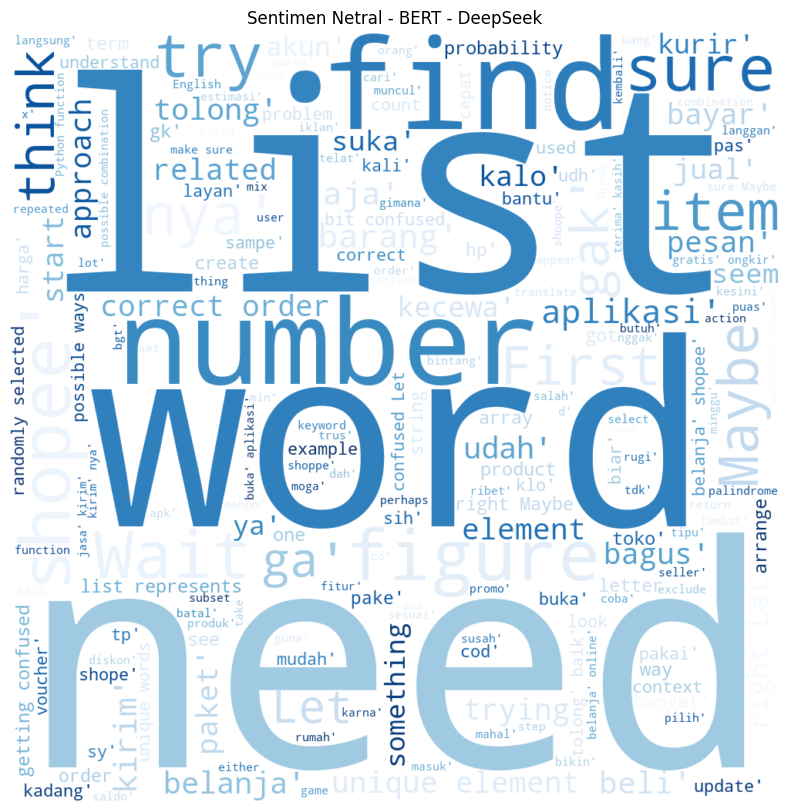

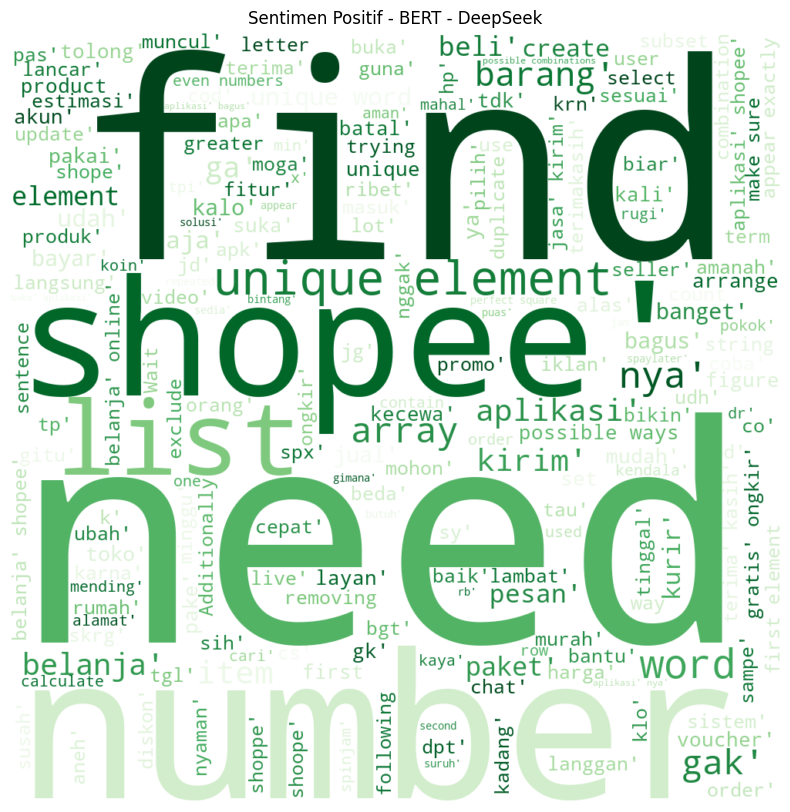

In [27]:
# WordCloud Sentimen Negatif (BERT)
text_neg_bert = ' '.join(df_DeepSeek_BERT[df_DeepSeek_BERT['BERT_Sentiment'] == 'Negative']['Translation'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neg_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif - BERT - DeepSeek")
plt.show()

# WordCloud Sentimen Netral (BERT)
text_neu_bert = ' '.join(df_DeepSeek_BERT[df_DeepSeek_BERT['BERT_Sentiment'] == 'Neutral']['Translation'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_neu_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Netral - BERT - DeepSeek")
plt.show()

# WordCloud Sentimen Positif (BERT)
text_pos_bert = ' '.join(df_DeepSeek_BERT[df_DeepSeek_BERT['BERT_Sentiment'] == 'Positive']['Translation'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(text_pos_bert)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif - BERT - DeepSeek")
plt.show()


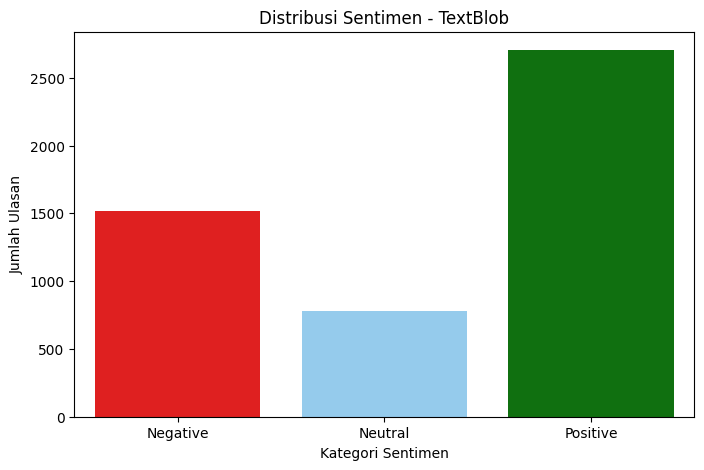

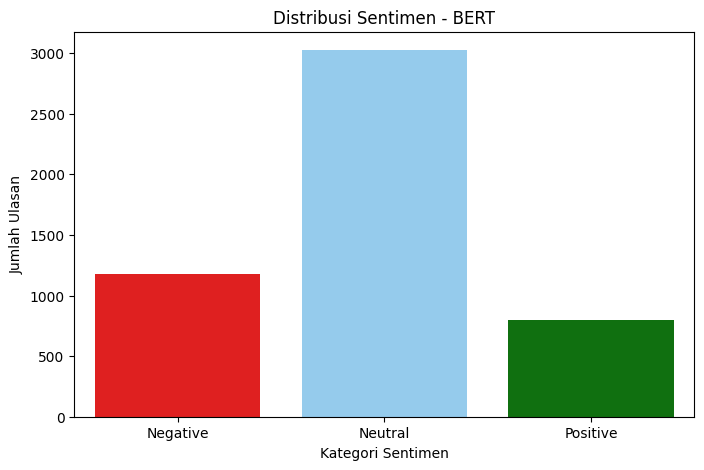

In [28]:
# Hitung jumlah kategori sentimen untuk TextBlob
sentimen_blob = df_DeepSeek_textBlob['Sentiment'].value_counts()

# Hitung jumlah kategori sentimen untuk BERT
sentimen_bert = df_DeepSeek_BERT['BERT_Sentiment'].value_counts()

# Pastikan kategori diurutkan dengan benar
order = ['Negative', 'Neutral', 'Positive']
colors = {'Negative': 'red', 'Neutral': 'lightskyblue', 'Positive': 'green'}

# **Visualisasi Sentimen TextBlob**
plt.figure(figsize=(8, 5))
sns.barplot(x=sentimen_blob.index, y=sentimen_blob.values, hue=sentimen_blob.index, 
            order=order, palette=colors, legend=False)
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Sentimen - TextBlob")
plt.show()

# **Visualisasi Sentimen BERT**
plt.figure(figsize=(8, 5))
sns.barplot(x=sentimen_bert.index, y=sentimen_bert.values, hue=sentimen_bert.index, 
            order=order, palette=colors, legend=False)
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Sentimen - BERT")
plt.show()
